In [1]:
import torch
import torch.nn as nn
import torchvision as tv
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as Func


In [2]:
logostxt=open("D:/Downloads/datasets/mini_logo_good/spisok.txt")
logos_list=logostxt.read().split("\n")
#logos_list=['Burger King','KFC','McDonalds','Other','Starbucks','Subway']
logos_list.sort()
CountOfClasses=len(logos_list)
logos_list

['ABLE',
 'AC',
 'ACID',
 'AFernandez',
 'ALCO',
 'AND1',
 'Acorn',
 'AdanyEva',
 'Addidas',
 'Advent',
 'Alliance',
 'AlmostSkateboards',
 'Always',
 'Amador',
 'Amoco',
 'Amsterdam',
 'Anchorage',
 'Animal',
 'Ankara',
 'Annapurna']

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device is',device)

device is cpu


In [4]:
path = 'D:/Downloads/datasets/mini_logo_good/train'

In [5]:
transforms=tv.transforms.Compose([
    tv.transforms.Resize((70,70)),
    tv.transforms.ToTensor()
    
])

In [6]:
from matplotlib.transforms import Transform
dataset=tv.datasets.ImageFolder(root=path,transform=transforms)

In [7]:
dataloader=torch.utils.data.DataLoader(dataset,batch_size=4,shuffle=True,num_workers=2)

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608],
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608],
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608]],

        [[0.1529, 0.1529, 0.1529,  ..., 0.1529, 0.1529, 0.1529],
         [0.1529, 0.1529, 0.1529,  ..., 0.1529, 0.1529, 0.1529],
         [0.1529, 0.1529, 0.1529,  ..., 0.1529, 0.1529, 0.1529],
         ...,
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608],
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608],
         [0.5608, 0.5608, 0.5608,  ..., 0.5608, 0.5608, 0.5608]],

        [[0.1725, 0.1725, 0.1725,  ..., 0.1725, 0.1725, 0.1725],
         [0.1725, 0.1725, 0.1725,  ..., 0.1725, 0.1725, 0.1725],
         [0.1725, 0.1725, 0.1725,  ..., 0.1725, 0.1725, 0

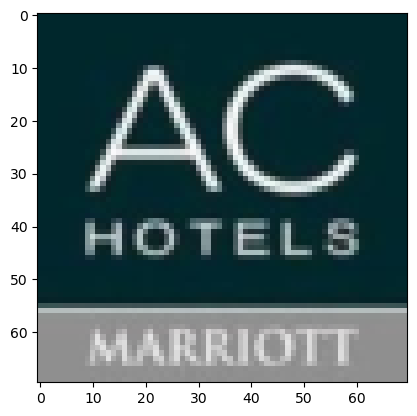

In [8]:
plt.imshow(dataset[118][0].numpy().transpose((1,2,0)))
print(dataset[118])
#print(dataset[50][0].numpy().transpose((1,2,0)).shape)
#print(dataset[50][0].shape)
#m=nn.Conv2d(3,32,kernel_size=3,padding=0)
#m=nn.AdaptiveAvgPool2d((1,1))
#print(m(dataset[50][0]).shape) 
#plt.imshow(m(dataset[50][0]).numpy().transpose((1,2,0)))
#print(dataset[50])

In [9]:
class CNA(nn.Module):
  def __init__(self,in_ch=32,out_ch=32):
    super().__init__()
    self.conv=nn.Conv2d(in_ch,out_ch,kernel_size=3,padding=1)
    self.norm=nn.BatchNorm2d(out_ch)
    self.act=nn.ReLU()

  def forward(self,x):
    out=self.conv(x)
    out=self.norm(out)
    out=self.act(out)
    return out
net=CNA()
net=net.to(device)

In [10]:
class MyConvModel(nn.Module):
  def __init__(self, base_ch=32):
    super().__init__()
    cna1_1=CNA(3,base_ch) 
    cna1_2=CNA(base_ch,base_ch) 
    cna2_1=CNA(base_ch,2*base_ch)
    cna2_2=CNA(2*base_ch,2*base_ch)
    cna3_1=CNA(2*base_ch,4*base_ch)
    cna3_2=CNA(4*base_ch,4*base_ch)
    cna4_1=CNA(4*base_ch,8*base_ch)
    cna4_2=CNA(8*base_ch,8*base_ch)
    cna5_1=CNA(8*base_ch,16*base_ch)
    cna5_2=CNA(16*base_ch,16*base_ch)
    cna6_1=CNA(16*base_ch,32*base_ch)
    act=nn.ReLU()
    Linear_1=nn.Linear(32*base_ch,16*base_ch)
    Linear_2=nn.Linear(16*base_ch,CountOfClasses)
    maxpool=nn.MaxPool2d(2,2)
    avgpool=nn.AdaptiveAvgPool2d((1,1))
    flatten=nn.Flatten()
    self.model = nn.Sequential(
          cna1_1,cna1_2,maxpool,# (16,3,60,60)-> (16,32,30,30)
          cna2_1,cna2_2,maxpool,#(16,32,30,30)->(16,64,15,15)
          cna3_1,cna3_2,maxpool,
          cna4_1,cna4_2,maxpool,
          cna5_1,cna5_2,maxpool,
          cna6_1,avgpool,
          flatten,Linear_1,act,
          Linear_2
    )
  def forward(self,x):
    return self.model(x)
net=MyConvModel()
net=net.to(device)

In [11]:
vggNet=tv.models.vgg.vgg19(weights=tv.models.VGG19_Weights)
classifier=nn.Sequential(
    nn.Linear(25088,600),
    nn.ReLU(),
    nn.Linear(600,600),
    nn.ReLU(),
    nn.Linear(600,CountOfClasses)
)
vggNet.classifier=classifier
for param in vggNet.features.parameters():
    param.requires_grad=False
#net = SimpleConvNet()
net=vggNet
net = net.to(device)

C:\Users\lain\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\lain/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [12]:
#loss_fn = nn.CrossEntropyLoss()
loss_fn=nn.MSELoss()
#optimizer=torch.optim.Adam(net.parameters(),lr=1e-4, betas=(0.9, 0.999))
optimizer=torch.optim.Adam(net.classifier.parameters(),lr=1e-4, betas=(0.9, 0.999))
def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)
print(count_parameters(net))

15426020


In [13]:
def get_accuracy(pred, label):
    answer =(pred.argmax(1)==label.argmax(1)).type(torch.float).sum().item()

    #answer = pred.detach().numpy().argmax(1) == label.numpy().argmax(1) 
    return answer

In [14]:
epochs=5
for epoch in range(epochs):
    loss_val=0
    acc_val=0

    for sample in dataloader:
        img,label = sample

        label = label.to(device)
        label = Func.one_hot(label, num_classes=CountOfClasses).float()
        # label=Func.one_hot(label,num_classes=10)
        #label = label.float()
        #label = label.unsqueeze(1)
        img = img.to(device)
        
        optimizer.zero_grad()
       
        
        pred = net (img)

        loss = loss_fn(pred, label)
        loss.backward()

        optimizer.step()
        
        loss_val+=loss.item()
        acc_val += get_accuracy(pred.cpu(), label.cpu())

    loss_val /= len(dataloader)
    acc_val /= len(dataloader)*4
    print("epoch=",epoch,"loss=",loss_val ,"accruracy=",acc_val)

epoch= 0 loss= 0.04406446717577438 accruracy= 0.2856164383561644
epoch= 1 loss= 0.036419433186927884 accruracy= 0.4383561643835616
epoch= 2 loss= 0.03184948036931966 accruracy= 0.5636986301369863
epoch= 3 loss= 0.027570109255611895 accruracy= 0.6678082191780822
epoch= 4 loss= 0.02381142265393003 accruracy= 0.7431506849315068


In [15]:
torch.save(net, 'D:\\myprogect\\pytorch\\weightsOfLogoClassifierbatch1')

In [16]:
#net = MyConvModel()
net = torch.load('D:\\myprogect\\pytorch\\weightsOfLogoClassifierbatch1')
#net.eval()

Test for one image

[-0.0162491612136364, 0.03672218322753906, 0.05101967230439186, -0.035597845911979675, 0.07148581743240356, 0.15400002896785736, 0.02724248170852661, 0.007769934833049774, 0.053132064640522, 0.04183892160654068, 0.006260983645915985, 0.037668440490961075, 0.18285031616687775, 0.06164471060037613, -0.007590334862470627, 0.06865771114826202, 0.06194351986050606, 0.0018118210136890411, -0.015218093991279602, 0.04427899047732353]
0.18285031616687775
12
Always
0.8336721621453762


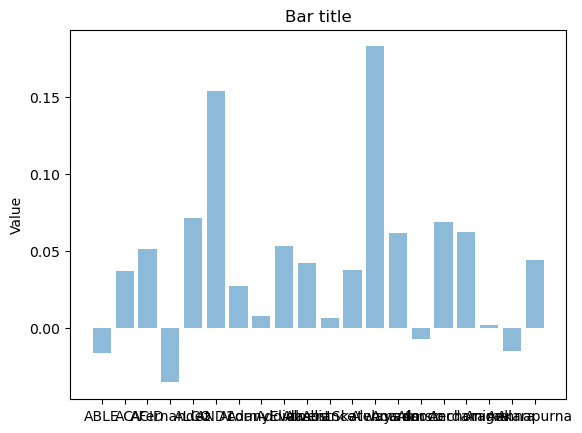

In [22]:
path="D:/Downloads/datasets/mini_logo_good/test1/11/40jpg.jpg"
img=Image.open(path)
tensorImg=transforms(img)
batchImg=torch.unsqueeze(tensorImg,0)
out=net(batchImg)
test=out
out=out.squeeze()
out=out.tolist()
print(out)
print(max(out))
print(out.index(max(out)))
print(logos_list[out.index(max(out))])
print(sum(out))
y_pos = np.arange(len(logos_list))
plt.bar(y_pos, out, align='center', alpha=0.5)
plt.xticks(y_pos, logos_list)
plt.ylabel('Value')
plt.title('Bar title')

plt.show()
# dataset=tv.datasets.ImageFolder(root=path,transform=transforms)
# #print(dataset[0])
# testloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=True)
# for sample in testloader:
#   img,label = sample
#   img=img.to(device)
#   pred=net(img)
  
#   pred=max(pred).tolist()
#   print(pred)
#   print(pred.index(max(pred)))
#   print(max(pred))
#   print(logos_list[ pred.index(max(pred))])

test for test dataset

In [18]:
a=np.zeros(20)
path = 'D:/Downloads/datasets/mini_logo_good/train'
dataset=tv.datasets.ImageFolder(root=path,transform=transforms)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=True,num_workers=4)
loss_val=0
acc_val=0
for sample in dataloader:
    img,label = sample

    label = label.to(device)
    label = Func.one_hot(label, num_classes=CountOfClasses).float()
        # label=Func.one_hot(label,num_classes=10)
        #label = label.float()
        #label = label.unsqueeze(1)
    img = img.to(device) 
    pred = net (img)
    out=pred.squeeze()
    out=out.tolist()
    a[out.index(max(out))]+=1
    loss = loss_fn(pred, label)
         
    loss_val+=loss.item()
    acc_val += get_accuracy(pred.cpu(), label.cpu())
    
loss_val /= len(dataloader)
acc_val /= len(dataloader)
print("loss=",loss_val ,"accruracy=",acc_val)
print(a)

loss= 0.019157162819492087 accruracy= 0.8629198080877313
[ 76.  79.  48.  64. 101.  63.  41.  77.  89.  80.  62.  79.  88.  76.
  83.  41.  59.  98.  85.  70.]


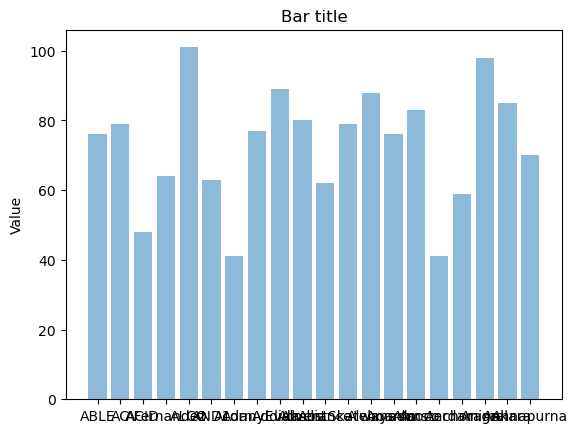

In [19]:
y_pos = np.arange(len(logos_list))
plt.bar(y_pos, a, align='center', alpha=0.5)
plt.xticks(y_pos, logos_list)
plt.ylabel('Value')
plt.title('Bar title')

plt.show()

эта хуйня не работает